In [11]:
from IPython.display import display, HTML, IFrame

### PyData London 2015


#Getting meaning from scientific articles


## Eleonore Mayola, PhD
####Data Scientist at Mastodonc
####Co-organiser at PyLadies London

<h6><b>PyData London 2015</b> - <em>@EleonoreMayola</em></h6>

####Getting meaning from scientific articles

1- Who I am

2- What's this about

3- How I planned for this project

4- How I executed my plan

5- What went wrong

6 - What's next



####Getting meaning from scientific articles

__1- Who I am__

2- What's this about

3- How I planned for this project

4- How I executed my plan

5- What went wrong

6 - What's next

####Who I am

* Background in biomedical research -> no programming experience

* Learned Python at an intensive software eng course -> career change

* Magically turned into a developer -> full-stack web dev + Python scripting

* Now "data scientist" -> science / research + software / web development


=> What would I have done had I known how to code back in my lab days?

####Getting meaning from scientific articles

1- Who I am

__2- What's this about__

3- How I planned for this project

4- How I executed my plan

5- What went wrong

6 - What's next


####What's this about

*Problem*: Scientists have to regularly scan through the recent publications in their area.
   
   __How to make the bibliography process less time-consuming?__



*Idea*: Gather info from scientific articles of different the subcategories (I focused on Biology).

__Be able to classify a new article in one of those sub-categories__

####Getting meaning from scientific articles

1- Who I am

2- What's this about

__3- How I planned for this project__

4- How I executed my plan

5- What went wrong

6 - What's next

####How I planned for this project

     
     
                        NLTK                                        
  Articles subject A    ---->   most frequent terms (A)  --------
                                                                -
                                                                  SciKit-Learn
                                                                  ------------>  Classifier to predict if an
                                                                                 article is of subcategory A or B
                        NLTK                                    -
  Articles subject B    ---->   most frequent terms (B)  --------
                                          
                                                           

####Getting meaning from scientific articles

1- Who I am

2- What's this about

3- How I planned for this project

__4- How I executed my plan__

5- What went wrong

6 - What's next

####How I executed my plan


STEP 1: Gathering scientific articles


                        NLTK                                        
  Articles subject A    ---->   most frequent terms (A)  --------
                                                                -
                                                                  SciKit-Learn
                                                                  ------------>  Classifier to predict if an
                                                                                 article is of subcategory A or B
                        NLTK                                    -
  Articles subject B    ---->   most frequent terms (B)  --------

####How I executed my plan


STEP 1: Gathering scientific articles

1 - Yay for Open Access research articles!

2 - Hmmm, where's the API?

3 - My solution: eLifeScience articles on Github (http://github.com/elifesciences/elife-articles)

4 - Parsing XML files using Beautiful Soup -> Group A: "Neuroscience" - Group B: "Cell biology"


####How I executed my plan


STEP 2: Retrieve the most frequent terms


                        NLTK                                        
  Articles subject A    ---->   most frequent terms (A)  --------
                                                                -
                                                                  SciKit-Learn
                                                                  ------------>  Classifier to predict if an
                                                                                 article is of subcategory A or B
                        NLTK                                    -
  Articles subject B    ---->   most frequent terms (B)  --------

####How I executed my plan


STEP 2: Retrieve the most frequent terms
 
-> Use Nltk and Gensim libraries to implement the TF-IDF (Term frequency–inverse document frequency) model

In [1]:
import string

from nltk.stem.wordnet import WordNetLemmatizer

from gensim import models
from gensim.corpora import Dictionary

## Example text:
zen = ["Beautiful is better than ugly. Explicit is better than implicit.", 
        "Simple is better than complex. Complex is better than complicated.",
        "Flat is better than nested. Sparse is better than dense.",
        "Readability counts. Special cases aren't special enough to break the rules.",
        "Although practicality beats purity. Errors should never pass silently.",
        "Unless explicitly silenced. In the face of ambiguity, refuse the temptation to guess." ,
        "There should be one-- and preferably only one --obvious way to do it.",
        "Although that way may not be obvious at first unless you're Dutch.",
        "Now is better than never. Although never is often better than *right* now.",
        "If the implementation is hard to explain, it's a bad idea.",
        "If the implementation is easy to explain, it may be a good idea."
        "Namespaces are one honking great idea -- let's do more of those!"]

In [2]:
## TOKENISATION: Breaking down a text in meaningful elements
texts = [text.lower().replace('\n', ' ').split(' ') for text in zen]

stop_words = ['a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for'
             'from', 'has', 'he', 'if', 'in', 'is', 'it', 'its', 'it\'s', 'of', 'on', 
             'than', 'that', 'the', 'to', 'was', 'were', 'will', 'with']

docs = [[filter(lambda x:x not in string.punctuation, i) for i in txt if i != '' and i not in stop_words] 
        for txt in texts]
print docs

[['beautiful', 'better', 'ugly', 'explicit', 'better', 'implicit'], ['simple', 'better', 'complex', 'complex', 'better', 'complicated'], ['flat', 'better', 'nested', 'sparse', 'better', 'dense'], ['readability', 'counts', 'special', 'cases', 'arent', 'special', 'enough', 'break', 'rules'], ['although', 'practicality', 'beats', 'purity', 'errors', 'should', 'never', 'pass', 'silently'], ['unless', 'explicitly', 'silenced', 'face', 'ambiguity', 'refuse', 'temptation', 'guess'], ['there', 'should', 'one', 'preferably', 'only', 'one', 'obvious', 'way', 'do', 'it'], ['although', 'way', 'may', 'not', 'obvious', 'first', 'unless', 'youre', 'dutch'], ['now', 'better', 'never', 'although', 'never', 'often', 'better', 'right', 'now'], ['implementation', 'hard', 'explain', 'bad', 'idea'], ['implementation', 'easy', 'explain', 'may', 'good', 'ideanamespaces', 'one', 'honking', 'great', 'idea', '', 'lets', 'do', 'more', 'those']]


In [3]:
## LEMMATISATION: Grouping together the different forms of a word
lmtzr = WordNetLemmatizer()
lemm = [[lmtzr.lemmatize(word) for word in data] for data in docs]
print lemm

[['beautiful', 'better', 'ugly', 'explicit', 'better', 'implicit'], ['simple', 'better', 'complex', 'complex', 'better', 'complicated'], ['flat', 'better', 'nested', 'sparse', 'better', 'dense'], ['readability', u'count', 'special', u'case', 'arent', 'special', 'enough', 'break', u'rule'], ['although', 'practicality', u'beat', 'purity', u'error', 'should', 'never', u'pas', 'silently'], ['unless', 'explicitly', 'silenced', 'face', 'ambiguity', 'refuse', 'temptation', 'guess'], ['there', 'should', 'one', 'preferably', 'only', 'one', 'obvious', 'way', 'do', 'it'], ['although', 'way', 'may', 'not', 'obvious', 'first', 'unless', 'youre', 'dutch'], ['now', 'better', 'never', 'although', 'never', 'often', 'better', 'right', 'now'], ['implementation', 'hard', 'explain', 'bad', 'idea'], ['implementation', 'easy', 'explain', 'may', 'good', 'ideanamespaces', 'one', 'honking', 'great', 'idea', '', u'let', 'do', 'more', 'those']]


In [4]:
## Create bag of words from dictionnary:
dictionary = Dictionary(lemm)
dictionary.save('text.dict')

## Term frequency–inverse document frequency (TF-IDF)
## Method to reflect how important a word is to a document in a collection of documents.
## The inverse document frequency measures whether the term is common or rare across all documents.

bow = [dictionary.doc2bow(l) for l in lemm] # Calculates inverse document counts for all terms
print "BAG OF WORDS: Assign a frequency to a word index \n", bow

BAG OF WORDS: Assign a frequency to a word index 
[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1)], [(1, 2), (5, 2), (6, 1), (7, 1)], [(1, 2), (8, 1), (9, 1), (10, 1), (11, 1)], [(12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2)], [(20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1)], [(29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1)], [(27, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1)], [(20, 1), (36, 1), (39, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1)], [(1, 2), (20, 1), (23, 2), (50, 2), (51, 1), (52, 1)], [(53, 1), (54, 1), (55, 1), (56, 1), (57, 1)], [(37, 1), (40, 1), (47, 1), (54, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1)]]


In [5]:
# Transform the count representation into the Tfidf space
tfidf = models.TfidfModel(bow)              
corpus_tfidf = tfidf[bow]
print "\nTF-IDF: value associated with the importance of word in a document\n"
for doc in corpus_tfidf:
    print doc


TF-IDF: value associated with the importance of word in a document

[(0, 0.46068284809775906), (1, 0.38869686630348355), (2, 0.46068284809775906), (3, 0.46068284809775906), (4, 0.46068284809775906)]
[(1, 0.3256764163849216), (5, 0.7719822415102027), (6, 0.38599112075510134), (7, 0.38599112075510134)]
[(1, 0.38869686630348355), (8, 0.46068284809775906), (9, 0.46068284809775906), (10, 0.46068284809775906), (11, 0.46068284809775906)]
[(12, 0.30151134457776363), (13, 0.30151134457776363), (14, 0.30151134457776363), (15, 0.30151134457776363), (16, 0.30151134457776363), (17, 0.30151134457776363), (18, 0.30151134457776363), (19, 0.6030226891555273)]
[(20, 0.20048400621111767), (21, 0.3700038072053449), (22, 0.3700038072053449), (23, 0.2630487209385746), (24, 0.3700038072053449), (25, 0.3700038072053449), (26, 0.3700038072053449), (27, 0.2630487209385746), (28, 0.3700038072053449)]
[(29, 0.3650162883572298), (30, 0.3650162883572298), (31, 0.3650162883572298), (32, 0.3650162883572298), (33, 0.

In [6]:
## Build the LSI (latent semantic indexing) model
## Method to uses a mathematical technique called singular value decomposition (SVD) 
## to identify patterns in the relationships between the terms and concepts contained 
## in an unstructured collection of text.
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=3)
corpus_lsi = lsi[corpus_tfidf]

for doc in corpus_lsi:
    print(doc)

[(0, -0.54498357184461865), (1, 0.21260756377523921), (2, -0.2033190679339878)]
[(0, -0.49872076945560256), (1, 0.1969849532105663), (2, -0.20013466140694447)]
[(0, -0.54498357184461899), (1, 0.21260756377523851), (2, -0.2033190679339881)]
[]
[(0, -0.29788909810577979), (1, -0.11063707308686005), (2, 0.49983116799619021)]
[(0, -0.037992769637637043), (1, -0.088009881979444468), (2, 0.21744299165959061)]
[(0, -0.19434230433693714), (1, -0.52719369649662484), (2, 0.29033187162354313)]
[(0, -0.19783074635880774), (1, -0.38294184000348114), (2, 0.44863074249670343)]
[(0, -0.57585999369002594), (1, 0.099448153626818428), (2, 0.2313892314774415)]
[(0, -0.10520154691689336), (1, -0.50564529531779601), (2, -0.52535252894323925)]
[(0, -0.17251625291639155), (1, -0.69288699106334639), (2, -0.34135753883295689)]


In [7]:
for i in range(lsi.num_topics):
    print lsi.show_topic(i)

[(-0.54099716727821134, u'better'), (-0.27853037146820414, u'complex'), (-0.2773179509373383, u'now'), (-0.25384405967038426, u'never'), (-0.18163236900752383, u'nested'), (-0.18163236900752361, u'sparse'), (-0.18163236900752361, u'dense'), (-0.18163236900752361, u'beautiful'), (-0.18163236900752355, u'flat'), (-0.18163236900752355, u'implicit')]
[(-0.30794775806820107, u'one'), (-0.25292223047307416, u'explain'), (-0.25292223047307416, u'implementation'), (-0.25292223047307416, u'idea'), (-0.20778805050884358, u'do'), (-0.20437009294542927, u'bad'), (-0.20437009294542927, u'hard'), (0.19505419477989078, u'better'), (-0.18973512044056556, u'may'), (-0.18226648505043708, u'way')]
[(-0.24330841921959975, u'bad'), (-0.24330841921959975, u'hard'), (-0.23373524267885962, u'implementation'), (-0.23373524267885962, u'idea'), (-0.23373524267885962, u'explain'), (0.20928347389567176, u'never'), (0.20727316973039422, u'although'), (0.17738986606596632, u'should'), (0.1734276279728709, u'obvious'

In [8]:
list_topics = [] 
for i in range(lsi.num_topics):
    list_topics.extend(lsi.show_topic(i))

list_topics.sort(key=lambda tup: tup[0], reverse=True)

topics = [i[1] for i in list_topics]
print topics

[u'never', u'although', u'better', u'should', u'obvious', u'way', u'flat', u'implicit', u'sparse', u'dense', u'beautiful', u'nested', u'way', u'may', u'bad', u'hard', u'do', u'implementation', u'idea', u'explain', u'bad', u'hard', u'explain', u'implementation', u'idea', u'never', u'now', u'complex', u'one', u'better']


####How I executed my plan


STEP 2: Retrieve the most frequent terms
 
-> Convert the script to functions to be executed on a collection of text files (converted from XML)

In [14]:
# %load get_topics.py

#!/home/eleonore/virtenvs/nltk-gensim-skl/bin/python2.7
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import models
from gensim.corpora import Dictionary
from os import listdir
from os.path import isfile, join
import string, re, codecs, time, json


## Global variables
stop_words = ['a', 'also', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'but', 'for',
              'from', 'has', 'he', 'if', 'in', 'is', 'it', 'its', 'it\'s', 'not',
              'of', 'on', 'our', 'than', 'that', 'the', 'therefore', 'to', 'was',
              'were', 'will', 'with', 'may', 'need', 'have', 'been', 'their', 'this',
              'these', 'which', 'do', 'did', 'red', 'blue', 'green', 'bar', 'chart',
              'arrowhead', 'arrow', 'vice', 'versa']

spe_char = {u'β': 'beta', u'α': 'alpha', u'µm': 'micron'}

## Functions to break up the process:
def parse_text(text_file):
    "Gets a text file outputs a list of strings."
    with codecs.open(text_file, mode='r', encoding='utf-8') as f:
        read = f.read()
        r = [read.replace(unicode(i), spe_char.get(i)) for i in read if i in spe_char.keys()] or [read]
        text = [line for line in r[0].strip().split('. ') if line != '']
        return text
    
def get_tokens(text_parsed):
    "Gets a text and retrieves tokens."
    # Tokenisation
    texts = [t.lower().replace('\n', ' ').split(' ') for t in text_parsed]
    # Remove punctuation and stop words
    tokens = [[filter(lambda x:x not in string.punctuation, i)
               for i in txt if i != '' and i not in stop_words] for txt in texts]
    #print len(tokens), [len(txt) for txt in tokens]
    tokens_cleaned = [[i for i in txt if len(i) > 2 and not i.isdigit()] for txt in tokens]
    #print len(tokens_cleaned), [len(txt) for txt in tokens_cleaned]
    return tokens_cleaned

def lemmatize_tokens(tokens):
    "Gets tokens and retrieves lemmatised tokens."
    # Lemmatisation using nltk lemmatiser
    lmtzr = WordNetLemmatizer()
    lemma = [[lmtzr.lemmatize(word) for word in data] for data in tokens]
    return lemma

def bag_of_words(lemma):
    "Takes in lemmatised words and returns a bow."
    ## Create bag of words from dictionnary
    dictionary = Dictionary(lemma)
    dictionary.save('text.dict')
    ## Term frequency–inverse document frequency (TF-IDF)
    bow = [dictionary.doc2bow(l) for l in lemma] # Calculates inverse document counts for all terms
    return bow

def tfidf_and_lsi(lemma, bow):
    "Gets a bow and returns topics."
    dictionary = Dictionary(lemma)
    tfidf = models.TfidfModel(bow) # Transforms the count representation into the Tfidf space
    corpus_tfidf = tfidf[bow]
    ## Build the LSI model
    lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=6)
    corpus_lsi = lsi[corpus_tfidf]
    list_topics = []
    for i in range(lsi.num_topics):
        list_topics.extend(lsi.show_topic(i))
    list_topics.sort(key=lambda tup: tup[0], reverse=True)
    # for i in range(lsi.num_topics):
    #     list_topics.extend(lsi.show_topic(i))
    topics = [i[1] for i in list_topics[:10]]
    return topics

## Function to retrieve topics using nltk
def get_topics(text_file):
    txt = parse_text(text_file)
    tokens = get_tokens(txt)
    #print tokens
    lemma = lemmatize_tokens(tokens)
    bow = bag_of_words(lemma)
    return tfidf_and_lsi(lemma, bow)

## Get all text articles from a path and retrieve topics:
def list_all_articles(path):
    articles = [f for f in listdir(path) if isfile(join(path, f))] or []
    print "There are %d articles in %s" % (len(articles), path)
    return {"path": path, "articles": articles}

# Write the topics to a json file:
#{"Neuroscience": {"pub_id1":[topics_file1], "pub_id2":[topics_file2]...},
# "Cell biology": {[], []...}}
def get_articles_topics(path, filename):
    "Store the topics in a json object and dump to a file."
    all_topics = {}
    #Get the directories in a path
    dirs = [d for d in listdir(path) if not isfile(join(path, d))]
    #For each dir and for each file in a dir
    for d in dirs:
        all_topics[d] = {}
        txt_files = [f for f in listdir(path+d) if isfile(join(path+d, f))]
        print txt_files
        for f in txt_files:
            all_topics[d][f[:-4]] = get_topics(path+d+'/'+f)
    with open(filename, 'w') as f:
        json.dump(all_topics, f)
    return all_topics
    

if __name__ == "__main__":

    neuro_articles = list_all_articles("articles/Neuroscience/")
    
    cellbiol_articles = list_all_articles("articles/Cell biology/")
    
    print get_topics(neuro_articles.get("path") + neuro_articles.get("articles")[0])

    #print get_articles_topics("articles/", "filenames_topics.json")   


There are 172 articles in articles/Neuroscience/
There are 67 articles in articles/Cell biology/
[u'vglut1', u'arrowhead', u'domain', u'dcvs', u'caps1', u'overlapping', u'arrowhead', u'vglut1', u'domain', u'secretion']


####How I executed my plan


STEP 3: Build a classifier to predict the subcategory of an article


                        NLTK                                        
  Articles subject A    ---->   most frequent terms (A)  --------
                                                                -
                                                                  SciKit-Learn
                                                                  ------------>  Classifier to predict if an
                                                                                 article is of subcategory A or B
                        NLTK                                    -
  Articles subject B    ---->   most frequent terms (B)  --------

####How I executed my plan


STEP 1: Exploring the data with Numpy and Scikit-learn

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import stats
import sklearn

%matplotlib inline
plt.style.use('ggplot')

with open("filenames_topics.json", 'r') as f:
        topics_articles = json.load(f)
        
print topics_articles['Neuroscience']['elife05116']

print topics_articles['Cell biology']['elife02923']

[u'scale', u'detected', u'inset', u'could', u'scale', u'rnai', u'antiphosphoret', u'development', u'control', u'receptor']
[u'allele', u'marker', u'vastus', u'lateralis', u'staining', u'ryr1ag', u'old', u'arrow', u'1year', u'background']


In [3]:
# List of most frequent terms
header = ['article', 'subject']

for subject, articles in topics_articles.iteritems():
    for pub_id, topics in articles.iteritems():
        header.extend(topics)        
        
print header[:15]

# Matrix representing the presence or absence of those terms in each article
top_data = []

for subject, articles in topics_articles.iteritems():
    for pub_id, topics in articles.iteritems():        
        ct = []
        ct.append(pub_id)
        ct.append(subject)
        tpcs = ['1' if h in topics else '0' for h in header[2:]]
        ct.extend(tpcs)
        top_data.append(ct)
        
print top_data[0][:15]

['article', 'subject', u'scale', u'detected', u'inset', u'could', u'scale', u'rnai', u'antiphosphoret', u'development', u'control', u'receptor', u'reduced', u'hand', u'reduced']
[u'elife05116', u'Neuroscience', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0', '0']


In [5]:
# Use a numpy array (data structure used with Scikit-learn)
topics_data = np.array(top_data)
print topics_data

## Data matrix: column 3 to the end
X = topics_data[:, 2:2392].astype(int)

## Class vector: column 2
Y = topics_data[:, 1] 

 [[u'elife05116' u'Neuroscience' u'1' ..., u'0' u'0' u'0']
 [u'elife02094' u'Neuroscience' u'0' ..., u'0' u'0' u'0']
 [u'elife01206' u'Neuroscience' u'0' ..., u'0' u'0' u'0']
 ..., 
 [u'elife04810' u'Cell biology' u'0' ..., u'0' u'0' u'0']
 [u'elife02678' u'Cell biology' u'0' ..., u'0' u'0' u'0']
 [u'elife05697' u'Cell biology' u'1' ..., u'1' u'1' u'1']]


In [6]:
print "\nX dimension: ", X.shape
print "Y dimension: ", Y.shape

Yfreq = sp.stats.itemfreq(Y)
print Yfreq
cb_total = int(Yfreq[0][1])
n_total = int(Yfreq[1][1])


X dimension:  (239, 2390)
Y dimension:  (239,)
[[u'Cell biology' u'67']
 [u'Neuroscience' u'172']]


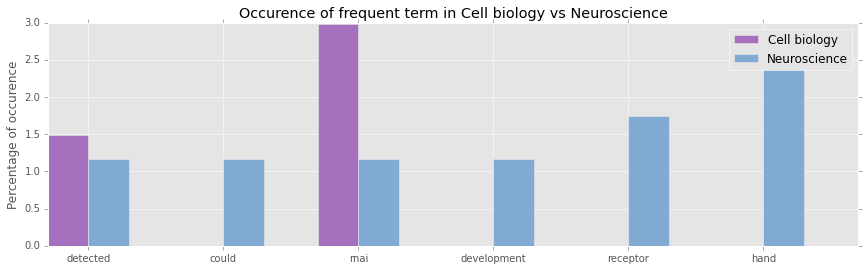

In [6]:
freqs_cb, freqs_n = [], []
R, N = range(3, 15, 2), len(range(3, 15, 2))

for j in R:
    cb = [int(i[1]) for i in topics_data[:, (1, j)] if i[0]=='Cell biology']
    n = [int(i[1]) for i in topics_data[:, (1, j)] if i[0]=='Neuroscience']
    cb_freq = sum(cb)*100./cb_total
    n_freq = sum(n)*100./n_total
    freqs_cb.append(cb_freq)
    freqs_n.append(n_freq)

ind = np.arange(N)
width = 0.3
fig, ax = plt.subplots()
rects_cb = ax.bar(ind, freqs_cb, width, color='#A770BF')
rects_n = ax.bar(ind+width, freqs_n, width, color='#81ABD3')

ax.set_ylabel('Percentage of occurence')
ax.set_title('Occurence of frequent term in Cell biology vs Neuroscience')
ax.set_xticks(ind+width)
xlabels = [header[i] for i in R]
ax.set_xticklabels(xlabels)
ax.legend((rects_cb[0], rects_n[0]), ('Cell biology', 'Neuroscience'))

fig.subplots_adjust(right=2)

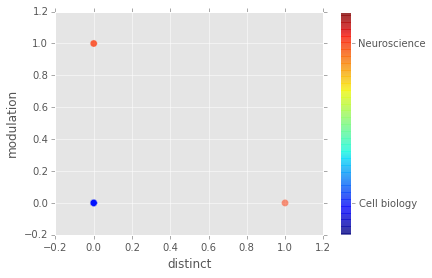

In [7]:
#x_index, y_index = 48, 350
x_index, y_index = 859, 179

classes = ['Cell biology', 'Neuroscience']
formatter = plt.FuncFormatter(lambda i, *args: classes[int(i)])

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Y)
targets = le.transform(Y)

plt.scatter(topics_data[:, x_index], topics_data[:, y_index],
            s=50, c=targets, alpha=0.5)
plt.colorbar(ticks=[0, 1], format=formatter)
plt.clim(-0.2, 1.2)
plt.xlabel(header[x_index])
plt.ylabel(header[y_index])

####How I executed my plan


STEP 2: Try statistical models

In [10]:
## why the NB model

In [7]:
## NAIVE BAYES MODEL:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics, preprocessing
from sklearn.cross_validation import train_test_split

## Encode labels ('Cell biology', 'Neuroscience') as 0 and 1.
le = preprocessing.LabelEncoder()
le.fit(Y)
y_transformed = le.transform(Y)
#print Y
#print y_transformed
## => 1: Neuroscience, 0: Cell biology

## Randomly split the data between training and testing:
X_train, X_test, Y_train, Y_test = train_test_split(X, y_transformed)

nbmodel_train = GaussianNB().fit(X_train, Y_train)
predicted_nb = nbmodel_train.predict(X_test)

In [8]:
## NB Model efficiency

## Confusion matrix:
cm_nb = metrics.confusion_matrix(Y_test, predicted_nb)
print "True positive: %d - False negative: %d" % (cm_nb[0][0], cm_nb[0][1])
print "False positive: %d - True negative: %d \n" % (cm_nb[1][0], cm_nb[1][1])

# Precision: fraction of retrieved instances that are relevant, TP / TP + FP
# Recall: fraction of relevant instances that are retrieved
print metrics.classification_report(Y_test, predicted_nb)

# Accuracy: overall correctness of the model
print "Accuracy: ", metrics.accuracy_score(Y_test, predicted_nb) 

## => Test with a high precision and recall for class 1 = Neuroscience

True positive: 9 - False negative: 12
False positive: 4 - True negative: 35 

             precision    recall  f1-score   support

          0       0.69      0.43      0.53        21
          1       0.74      0.90      0.81        39

avg / total       0.73      0.73      0.71        60

Accuracy:  0.733333333333


In [14]:
## why the KNN model

In [9]:
## K NEAREST NEIGHBOUR MODEL
from sklearn import metrics
from sklearn import neighbors

knnk3 = neighbors.KNeighborsClassifier(n_neighbors=3).fit(X, y_transformed)
predicted_k3 = knnk3.predict(X)

knnk5 = neighbors.KNeighborsClassifier(n_neighbors=5).fit(X, y_transformed)
predicted_k5 = knnk5.predict(X)

knnk15 = neighbors.KNeighborsClassifier(n_neighbors=15).fit(X, y_transformed)
predicted_k15 = knnk15.predict(X)

print "Accuracy 3 NN: ", metrics.accuracy_score(y_transformed, predicted_k3)
print "Accuracy 5 NN: ", metrics.accuracy_score(y_transformed, predicted_k5)
print "Accuracy 15 NN: ", metrics.accuracy_score(y_transformed, predicted_k15)

Accuracy 3 NN:  0.92050209205
Accuracy 5 NN:  0.874476987448
Accuracy 15 NN:  0.799163179916


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y_transformed)

knn = neighbors.KNeighborsClassifier(n_neighbors=3).fit(X_train, Y_train)
predicted_knn = knn.predict(X_test)

cm_knn = metrics.confusion_matrix(Y_test, predicted_knn)
print "True positive: %d - False negative: %d" % (cm_knn[0][0], cm_knn[0][1])
print "False positive: %d - True negative: %d \n" % (cm_knn[1][0], cm_knn[1][1])

# Precision: fraction of retrieved instances that are relevant, TP / TP + FP
# Recall: fraction of relevant instances that are retrieved
print metrics.classification_report(Y_test, predicted_knn)

True positive: 2 - False negative: 7
False positive: 2 - True negative: 49 

             precision    recall  f1-score   support

          0       0.50      0.22      0.31         9
          1       0.88      0.96      0.92        51

avg / total       0.82      0.85      0.82        60



In [13]:
# Model validation

####Getting meaning from scientific articles

1- Who I am

2- What's this about

3- How I planned for this project

4- How I executed my plan

__5- What went wrong__

6 - What's next

####What went wrong

= Lessons learned!


* Dude, where's my data!?

* Unicode hurts :-/

* Low model performance

####Getting meaning from scientific articles

1- Who I am

2- What's this about

3- How I planned for this project

4- How I executed my plan

5- What went wrong

__6 - What's next__

####What's next

Improvements ideas:

* Data quantity/quality: scrape OA articles

* Text analysis: bow (bag of words) vs word2vec

* Text analysis: unigrams vs n-grams


##That's all folks!

###Questions and advice welcome =)

####@EleonoreMayola
